In [1]:
from IPython.display import Image
import tensorflow as tf
# import preprocessing as pre
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import time
import cv2
import pathlib
from sklearn.model_selection import train_test_split
from shutil import copyfile
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,Softmax
from tensorflow.keras import Model, Sequential
import os
import keras.backend as K

Using TensorFlow backend.


In [ ]:
# This section need not be edited (It is intended to setup the working environment for tensorflow)

In [ ]:
def config_gpu():
    #Configure Gpus
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
        # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
            print(e)

In [ ]:
config_gpu()
print(tf.__file__)

In [ ]:
#Checkpoint 1: Define Training/Test data size and dimension and explain the rationale for your selection------------------------

In [ ]:
X= []
y=[]
pwd=os.getcwd()
for labels in os.listdir(pwd+"\\Data\\"):
    print(labels)
    for files in os.listdir(pwd+"\Data\\"+labels+"\\"):
        X.append(pwd+"\\Data\\"+labels+"\\"+files)
        y.append(files.split("-")[1])
print(len(X))
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)
# os.mkdir(pwd+"\\Test")
# os.mkdir(pwd+"\\Train")
# for X in X_train:
#     copyfile(X, pwd+"\\Train\\"+X.split("\\")[-1])
# for X in X_test:
#     copyfile(X, pwd+"\\Test\\"+X.split("\\")[-1])
  

In [ ]:
#Preprocessing Images Functions:
def labeller(Label):  # return on hot encoder

    if  "CNV" in Label:
        return 0.0
    if "DRUSEN" in Label:
        return 1.0
    if "DME" in Label:
        return 2.0
    if "NORMAL" in Label:

        return 3.0

    
files_name =os.listdir(".\\Train\\")
labels= [labeller(f) for f in files_name]
files_name =os.listdir(".\\Test\\")
labels2= [labeller(f) for f in files_name]

In [11]:
# base_dir = pathlib.Path('/content/drive/Shareddrives/My Drive/Term_7_AI_and_healthcare/Problemset 1/Data/')
list_ds= tf.data.Dataset.list_files(".\\Train\\*")
test_ds= tf.data.Dataset.list_files(".\\Test\\*")
# pre_processing =tf.keras.preprocessing.image_dataset_from_directory(
#     "/content/drive/Shareddrives/My Drive/Term_7_AI_and_healthcare/Problemset 1/Data/" ,
#     labels="inferred",
#     label_mode="int",
#     class_names=None,
#     color_mode="grayscale",
#     batch_size=32,
#     image_size=(WIDTH, HEIGHT),
#     shuffle=True,
#     seed=123,
#     validation_split=Test_size,
#     subset="validation",
#     interpolation="bilinear",
# )
train_label= tf.constant(labels)
test_label= tf.constant(labels2)
train_label=tf.reshape(train_label,(-1,1))
train_labels= tf.data.Dataset.from_tensor_slices(train_label)
test_labels= tf.data.Dataset.from_tensor_slices(test_label)

# train_labels=train_labels.shuffle(1000)
# for i in train_labels:
#     print(i)

In [12]:

def img_preprocess (image_file,target_size):
    
    image=tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.int32)
    image_resized = tf.image.resize(image ,[target_size[0], target_size[1]])
    image_resized=image_resized/255
#     print(tf.print(image_file))
#     if tf.size(image_file) >1:
#         image_file= tf.reshape(image_file,(tf.size(image_file),1))
#         label=  tf.map_fn(labeller,image_file)
#     print(int(tf.size(image_file)))
#     print(image_resized)
    # print(label[3:10])
    # print(image_file)
#     else:
#         img_label =labeller(label)
#     print(img_label)
    return image_resized


In [13]:
#Create a tensorflow pipeline and load and preprocess the data

In [14]:
pre_function = partial(img_preprocess,target_size=(224,224))
train_image= list_ds.map(pre_function)
train_data= tf.data.Dataset.zip((train_image,train_labels)).shuffle(10000).batch(32)
test_image=test_ds.map(pre_function)
test_data= tf.data.Dataset.zip((test_image,test_labels)).batch(1)

In [15]:
# for image in test_ds:
#     image, label =pre_function(image)
# #     print(label)
# for i , j in train_data:
# #     pred =model(i)
# #     print(pred)
#     print(j)

In [16]:
#Checkpoint 2: Print a sample of the data and explain the selected range and the purpose of normalisation----------------------

I choose the normalization that is built-in with tensor flow, that is subtracted by the mean and divided by the standard deviation, this to ensure that each features has a similar range of input, so that thte gradient dont go out of control when optimizing

(32, 224, 224, 1)
(32, 1)


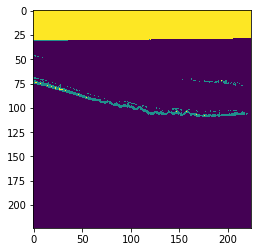

In [17]:
for images, labels in train_data.take(1):
    print(images.numpy().astype("uint8").shape)
    print(labels.shape)
    plt.imshow(images[1,:,:,0].numpy().astype("uint8"))

In [18]:
#Build Base Model (As defined in the exercise)

In [2]:
class MyModel(Model):
    def __init__(self):
        super(MyModel,self).__init__()
        self.conv1=Conv2D(10,(3,3),padding="valid", activation="relu")
        self.pool=MaxPooling2D(pool_size=(3,3), strides=2,padding="valid")
        self.flatten=Flatten()
        self.d1= Dense(128, activation='relu')
#         self.d2= Dense(64,activation="relu")
        self.d3= Dense (4,activation="softmax")
    def call(self, inputs, training=None, mask=None):
        inputs= self.conv1(inputs)
        inputs=self.pool(inputs)
        inputs= self.flatten(inputs)
        inputs = self.d1(inputs)
#         inputs = self.d2(inputs)
        return self.d3(inputs)
vmodel = Sequential()
vmodel.add(Conv2D(32,3,padding="same", activation="relu"))
vmodel.add(MaxPooling2D(pool_size=(2,2), strides=2,padding="same"))
vmodel.add(Flatten())
vmodel.add(Dense(256, activation='relu'))
vmodel.add( Dense(128,activation="relu"))
vmodel.add(Dense (4,activation="softmax"))
vmodel.compile()

In [3]:
#Checkpoint 3 Display the graph Print out of the model

In [4]:


vmodel.build(input_shape=(32,224,224,1))
vmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (32, 224, 224, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 112, 112, 32)        0         
_________________________________________________________________
flatten (Flatten)            (32, 401408)              0         
_________________________________________________________________
dense (Dense)                (32, 256)                 102760704 
_________________________________________________________________
dense_1 (Dense)              (32, 128)                 32896     
_________________________________________________________________
dense_2 (Dense)              (32, 4)                   516       
Total params: 102,794,436
Trainable params: 102,794,436
Non-trainable params: 0
__________________________________________

In [83]:
#Checkpoint 4: Explain selection of loss function and optimiser Optimizer


Sparse Categorical Crossentropy is a loss function that measure the loss of the results and it is used for class that are mutually exclusive and specifically used for classification problem .Optimising such loss means that our model is able to predict the class accurately.
Adam is a momentum based optimizer that works reliably that is able to update the parameters to lower to the loss 

In [82]:
#Define Loss function and Optimiser

In [22]:
loss_object= tf.keras.losses.SparseCategoricalCrossentropy()
optimizer= tf.keras.optimizers.Adam()

training_loss =tf.keras.metrics.Mean(name="Training Loss")
training_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name ="Training_accruacy")
# tf.constant([1.0,0.0,0.0,0.0])
# loss_object(tf.constant([1.0,0.0,0.0,0.0]), tf.constant([0.0,0.0,0.0,1.0]))
test_loss = tf.keras.metrics.Mean("Test_less")
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="Test_accuracy")

#     print(loss_object(j,pred))


In [23]:
#Define Training/Testing Function here

In [24]:
@tf.function
def train_steps(model, optimizer, images, labels):
    with tf.GradientTape() as tape:
        predictions= model(images)
        loss= loss_object(labels, predictions)
        gradient =tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradient, model.trainable_variables))
        training_loss(loss)
        training_accuracy(labels, predictions)
@tf.function
def test_step(model,images, labels):
    prediction=model(images)
    t_loss= loss_object(labels,prediction)
    test_loss(t_loss)
    test_accuracy(labels, prediction)



In [41]:
model = MyModel()
loss=[]
accur=[]

Epoch 1, Loss: 14.054891586303711, Accuracy: 29.84813117980957, Test Loss: 1.435817003250122, Test Accuracy: 29.772727966308594


In [6]:

for epoch in range(10):
    for image, label in train_data:
        train_steps(model,optimizer,image,label)
    for test_images, test_label in test_data:
        test_step(model, test_images,test_label)
    template= 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    this_loss=training_loss.result()
    this_accuracy=training_accuracy.result() *100
    loss.append(this_loss)
    accur.append(this_accuracy)
    print(template.format(epoch+1, this_loss, this_accuracy,
                          test_loss.result(), test_accuracy.result()*100))

NameError: name 'train_data' is not defined

In [25]:
#Checkpoint 5: Display training loss-epoch graph


In [5]:
plt.plot(loss)

NameError: name 'loss' is not defined

In [27]:
#Checkpoint 6: Display Accuracy-epoch graph

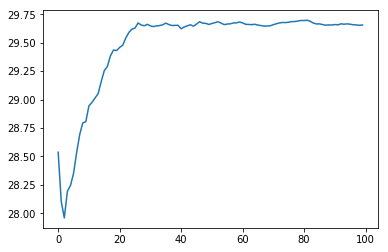

In [89]:
plt.plot(accur)

In [ ]:
#Checkpoint 7: Define and explain the choice of transfer base model for transfer learning

In [12]:
def img_preprocess2 (image_file,target_size):
    
    image=tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.int32)
    image= tf.image.grayscale_to_rgb(image)
    image_resized = tf.image.resize(image ,[target_size[0], target_size[1]])
    image_resized=tf.image.per_image_standardization(image_resized)
#     print(tf.print(image_file))
#     if tf.size(image_file) >1:
#         image_file= tf.reshape(image_file,(tf.size(image_file),1))
#         label=  tf.map_fn(labeller,image_file)
#     print(int(tf.size(image_file)))
#     print(image_resized)
    # print(label[3:10])
    # print(image_file)
#     else:
#         img_label =labeller(label)
    print(image_resized.shape)
    return image_resized


In [13]:
pre_function = partial(img_preprocess2,target_size=(224,224))
train_image= list_ds.map(pre_function)
train_data= tf.data.Dataset.zip((train_image,train_labels)).shuffle(10000).batch(32)
test_image=test_ds.map(pre_function)
test_data= tf.data.Dataset.zip((test_image,test_labels)).batch(1)

(224, 224, 3)
(224, 224, 3)


In [14]:
class NewModel(Model):
    def __init__(self):
        super(NewModel,self).__init__()
        self.based_model =tf.keras.applications.MobileNetV2(weights='imagenet', include_top = False)
        self.based_model.trainable = False
#         for layers in based_model.layers[:143]:
#             self.based_model.trainable=False
    
#         self.d2= Dense(64,activation="relu")
        self.flatten=Flatten()
        self.d2= Dense(128, activation='relu')
        self.d1= Dense (4,activation="softmax")
    def call(self, inputs, training=None, mask=None):
        based= self.based_model(inputs)
        flat = self.flatten(based)
        learnable= self.d2(flat)
        return self.d1(learnable)
newmodel=NewModel()
# based_model =tf.keras.applications.ResNet50(weights='imagenet', include_top = False)
# for layers in based_model.layers[:143]:
#     layers.trainable=False
    
# newmodel.add(based_model)
# # based_mdoel = Dense(128, activation ="relu")()
# newmodel.add( Dense (4,activation="softmax"))


In [21]:
new_loss_object= tf.keras.losses.SparseCategoricalCrossentropy()
new_optimizer= tf.keras.optimizers.Adam()

new_training_loss =tf.keras.metrics.Mean(name="Training Loss")
new_training_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name ="Training_accruacy")
# tf.constant([1.0,0.0,0.0,0.0])
# loss_object(tf.constant([1.0,0.0,0.0,0.0]), tf.constant([0.0,0.0,0.0,1.0]))
new_test_loss = tf.keras.metrics.Mean("Test_less")
new_test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="Test_accuracy")


@tf.function
def new_train_steps(model, optimizer, images, labels):
    with tf.GradientTape() as tape:
        predictions= model(images)
        loss= new_loss_object(labels, predictions)
        gradient =tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradient, model.trainable_variables))
        new_training_loss(loss)
        new_training_accuracy(labels, predictions)
@tf.function
def new_test_step(model,images, labels):
    prediction=model(images)
    t_loss= new_loss_object(labels,prediction)
    new_test_loss(t_loss)
    new_test_accuracy(labels, prediction)


In [24]:
loss=[]
accur=[]
for epoch in range(10):
    for image, label in train_data:
        new_train_steps(newmodel,new_optimizer,image,label)
    for test_images, test_label in test_data:
        new_test_step(newmodel, test_images,test_label)
    template= 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    this_loss=new_training_loss.result()
    this_accuracy=new_training_accuracy.result() *100
    loss.append(this_loss)
    accur.append(this_accuracy)
    print(template.format(epoch+1, this_loss, this_accuracy,
                          new_test_loss.result(), new_test_accuracy.result()*100))

Epoch 1, Loss: 1.33266282081604, Accuracy: 29.711442947387695, Test Loss: 1.3301396369934082, Test Accuracy: 29.72727394104004
Epoch 2, Loss: 1.3283852338790894, Accuracy: 29.440298080444336, Test Loss: 1.3276478052139282, Test Accuracy: 29.73484992980957
Epoch 3, Loss: 1.325514793395996, Accuracy: 29.483583450317383, Test Loss: 1.3260655403137207, Test Accuracy: 29.72727394104004
Epoch 4, Loss: 1.3232955932617188, Accuracy: 29.502487182617188, Test Loss: 1.3247976303100586, Test Accuracy: 29.72222328186035
Epoch 5, Loss: 1.321666955947876, Accuracy: 29.539445877075195, Test Loss: 1.3239707946777344, Test Accuracy: 29.718612670898438
Epoch 6, Loss: 1.3204454183578491, Accuracy: 29.563432693481445, Test Loss: 1.3233768939971924, Test Accuracy: 29.723485946655273
Epoch 7, Loss: 1.3194507360458374, Accuracy: 29.583749771118164, Test Loss: 1.3227605819702148, Test Accuracy: 29.720539093017578
Epoch 8, Loss: 1.318677544593811, Accuracy: 29.600000381469727, Test Loss: 1.322389841079712, Test

Definition : I have choosen MobilenetV2 as it has less parameters yet a very power network for image classification.  where the weight are set on imagenets, and I remove the last layers and replace it with a softmax function that output 4. 

In [ ]:
#Checkpoint 8: Display graph printout of the base model with the OCT image classication extension

In [33]:
# newmodel.compile()
newmodel.summary()


Model: "new_model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
flatten_2 (Flatten)          multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  8028288   
_________________________________________________________________
dense_4 (Dense)              multiple                  516       
Total params: 10,286,788
Trainable params: 8,028,804
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
#Checkpoint 9: The training data currently being used is simple and as such transfer learning isn't as advantageous,
#however some observations can be made when comparing the first model with the second, discuss these observation.

Although my results did not show an improvement and accruacy , I would like to mentioned the expected case. Where the accruacy and loss did not improve significantly. In the most of the cases, the pre-trained network has build up a good fundation on reading up images, thus it usually came with a sets pretrained filters that can recognize key features in the any images. This will allow the training of the new datasets taken place in a much shorter time. 

In [ ]:
#Checkpoint 10: Discuss why this may not be favourable and the problems it presents. 


Since there are less of CNV class, it means that the model has opportunity in learning the features of the CNV images, thus the model might not be accurate when predicting the CNV class or lower true positive rating. 

In [ ]:
#Checkpoint 11: Show some methods that can be utilised to negate or minimise these effects. 
#Compare the accuracy and explain the pros and cons of these techniques (If any) 

In [67]:
files=os.listdir("Train/")


'CNV-103044-10.jpeg'

In [74]:
def random_crop(image,target_size):
    image=tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.int32)
    cropped=tf.image.random_crop(image,size=(target_size[1],target_size[0],1))
    return cropped
def central_crop(image,target_size):  
    image=tf.io.read_file(image)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.int32)
    cropped=tf.image.central_crop(image,0.8)
    cropped =tf.image.resize(cropped ,[target_size[0], target_size[1]])
    return  tf.cast(cropped, tf.uint8)
for f in files:
    print("Train/"+f)
    image=central_crop("Train/"+file,target_size=(224,224))
    image=tf.image.encode_jpeg(image,format="grayscale")
    tf.io.write_file('augmented/test_sinogram.jpeg', image)

Train/CNV-103044-10.jpeg
Train/CNV-103044-100.jpeg
Train/CNV-103044-102.jpeg
Train/CNV-103044-103.jpeg
Train/CNV-103044-104.jpeg
Train/CNV-103044-105.jpeg
Train/CNV-103044-107.jpeg
Train/CNV-103044-109.jpeg
Train/CNV-103044-110.jpeg
Train/CNV-103044-112.jpeg
Train/CNV-103044-113.jpeg
Train/CNV-103044-115.jpeg
Train/CNV-103044-118.jpeg
Train/CNV-103044-119.jpeg
Train/CNV-103044-120.jpeg
Train/CNV-103044-121.jpeg
Train/CNV-103044-122.jpeg
Train/CNV-103044-123.jpeg
Train/CNV-103044-124.jpeg
Train/CNV-103044-128.jpeg
Train/CNV-103044-13.jpeg
Train/CNV-103044-133.jpeg
Train/CNV-103044-135.jpeg
Train/CNV-103044-137.jpeg
Train/CNV-103044-138.jpeg
Train/CNV-103044-139.jpeg
Train/CNV-103044-143.jpeg
Train/CNV-103044-145.jpeg
Train/CNV-103044-146.jpeg
Train/CNV-103044-147.jpeg
Train/CNV-103044-148.jpeg
Train/CNV-103044-149.jpeg
Train/CNV-103044-150.jpeg
Train/CNV-103044-153.jpeg
Train/CNV-103044-155.jpeg
Train/CNV-103044-156.jpeg
Train/CNV-103044-157.jpeg
Train/CNV-103044-159.jpeg
Train/CNV-1030

Train/CNV-154835-96.jpeg
Train/CNV-154835-98.jpeg
Train/CNV-163081-10.jpeg
Train/CNV-163081-100.jpeg
Train/CNV-163081-101.jpeg
Train/CNV-163081-102.jpeg
Train/CNV-163081-104.jpeg
Train/CNV-163081-106.jpeg
Train/CNV-163081-107.jpeg
Train/CNV-163081-11.jpeg
Train/CNV-163081-110.jpeg
Train/CNV-163081-111.jpeg
Train/CNV-163081-112.jpeg
Train/CNV-163081-113.jpeg
Train/CNV-163081-116.jpeg
Train/CNV-163081-117.jpeg
Train/CNV-163081-12.jpeg
Train/CNV-163081-120.jpeg
Train/CNV-163081-121.jpeg
Train/CNV-163081-122.jpeg
Train/CNV-163081-123.jpeg
Train/CNV-163081-124.jpeg
Train/CNV-163081-125.jpeg
Train/CNV-163081-128.jpeg
Train/CNV-163081-129.jpeg
Train/CNV-163081-131.jpeg
Train/CNV-163081-132.jpeg
Train/CNV-163081-133.jpeg
Train/CNV-163081-134.jpeg
Train/CNV-163081-135.jpeg
Train/CNV-163081-136.jpeg
Train/CNV-163081-137.jpeg
Train/CNV-163081-14.jpeg
Train/CNV-163081-141.jpeg
Train/CNV-163081-142.jpeg
Train/CNV-163081-144.jpeg
Train/CNV-163081-145.jpeg
Train/CNV-163081-146.jpeg
Train/CNV-163081-1

Train/DME-1141111-1.jpeg
Train/DME-1141111-3.jpeg
Train/DME-1141111-5.jpeg
Train/DME-1163718-1.jpeg
Train/DME-1163718-5.jpeg
Train/DME-1163718-6.jpeg
Train/DME-1163718-7.jpeg
Train/DME-1163718-8.jpeg
Train/DME-1163718-9.jpeg
Train/DME-1169820-1.jpeg
Train/DME-1169820-3.jpeg
Train/DME-1169820-4.jpeg
Train/DME-119840-1.jpeg
Train/DME-119840-11.jpeg
Train/DME-119840-12.jpeg
Train/DME-119840-13.jpeg
Train/DME-119840-15.jpeg
Train/DME-119840-17.jpeg
Train/DME-119840-19.jpeg
Train/DME-119840-2.jpeg
Train/DME-119840-20.jpeg
Train/DME-119840-21.jpeg
Train/DME-119840-22.jpeg
Train/DME-119840-25.jpeg
Train/DME-119840-6.jpeg
Train/DME-119840-7.jpeg
Train/DME-119840-8.jpeg
Train/DME-127971-1.jpeg
Train/DME-127971-2.jpeg
Train/DME-127971-3.jpeg
Train/DME-127971-4.jpeg
Train/DME-127971-5.jpeg
Train/DME-127971-6.jpeg
Train/DME-127971-8.jpeg
Train/DME-1356232-1.jpeg
Train/DME-15307-10.jpeg
Train/DME-15307-2.jpeg
Train/DME-15307-6.jpeg
Train/DME-15307-8.jpeg
Train/DME-15307-9.jpeg
Train/DME-1591159-1.j

Train/DME-1888479-15.jpeg
Train/DME-1888479-19.jpeg
Train/DME-1888479-2.jpeg
Train/DME-1888479-20.jpeg
Train/DME-1888479-21.jpeg
Train/DME-1888479-23.jpeg
Train/DME-1888479-24.jpeg
Train/DME-1888479-25.jpeg
Train/DME-1888479-26.jpeg
Train/DME-1888479-27.jpeg
Train/DME-1888479-28.jpeg
Train/DME-1888479-31.jpeg
Train/DME-1888479-34.jpeg
Train/DME-1888479-35.jpeg
Train/DME-1888479-37.jpeg
Train/DME-1888479-38.jpeg
Train/DME-1888479-41.jpeg
Train/DME-1888479-42.jpeg
Train/DME-1888479-43.jpeg
Train/DME-1888479-44.jpeg
Train/DME-1888479-47.jpeg
Train/DME-1888479-7.jpeg
Train/DME-1888479-8.jpeg
Train/DME-1893853-1.jpeg
Train/DME-1896542-10.jpeg
Train/DME-1896542-12.jpeg
Train/DME-1896542-13.jpeg
Train/DME-1896542-14.jpeg
Train/DME-1896542-15.jpeg
Train/DME-1896542-16.jpeg
Train/DME-1896542-17.jpeg
Train/DME-1896542-19.jpeg
Train/DME-1896542-20.jpeg
Train/DME-1896542-25.jpeg
Train/DME-1896542-26.jpeg
Train/DME-1896542-28.jpeg
Train/DME-1896542-29.jpeg
Train/DME-1896542-30.jpeg
Train/DME-189654

Train/DME-283376-1.jpeg
Train/DME-2834689-1.jpeg
Train/DME-2834689-3.jpeg
Train/DME-2834689-4.jpeg
Train/DME-2834689-5.jpeg
Train/DME-2834689-6.jpeg
Train/DME-285896-1.jpeg
Train/DME-2993521-1.jpeg
Train/DME-2993521-2.jpeg
Train/DME-2993521-3.jpeg
Train/DME-30521-100.jpeg
Train/DME-30521-103.jpeg
Train/DME-30521-104.jpeg
Train/DME-30521-105.jpeg
Train/DME-30521-106.jpeg
Train/DME-30521-108.jpeg
Train/DME-30521-109.jpeg
Train/DME-30521-11.jpeg
Train/DME-30521-111.jpeg
Train/DME-30521-113.jpeg
Train/DME-30521-114.jpeg
Train/DME-30521-116.jpeg
Train/DME-30521-117.jpeg
Train/DME-30521-119.jpeg
Train/DME-30521-12.jpeg
Train/DME-30521-120.jpeg
Train/DME-30521-121.jpeg
Train/DME-30521-122.jpeg
Train/DME-30521-123.jpeg
Train/DME-30521-124.jpeg
Train/DME-30521-127.jpeg
Train/DME-30521-128.jpeg
Train/DME-30521-131.jpeg
Train/DME-30521-132.jpeg
Train/DME-30521-133.jpeg
Train/DME-30521-134.jpeg
Train/DME-30521-136.jpeg
Train/DME-30521-137.jpeg
Train/DME-30521-138.jpeg
Train/DME-30521-14.jpeg
Train

Train/DME-3064922-225.jpeg
Train/DME-3064922-226.jpeg
Train/DME-3064922-228.jpeg
Train/DME-3064922-229.jpeg
Train/DME-3064922-23.jpeg
Train/DME-3064922-230.jpeg
Train/DME-3064922-231.jpeg
Train/DME-3064922-232.jpeg
Train/DME-3064922-233.jpeg
Train/DME-3064922-234.jpeg
Train/DME-3064922-235.jpeg
Train/DME-3064922-237.jpeg
Train/DME-3064922-238.jpeg
Train/DME-3064922-239.jpeg
Train/DME-3064922-24.jpeg
Train/DME-3064922-241.jpeg
Train/DME-3064922-243.jpeg
Train/DME-3064922-244.jpeg
Train/DME-3064922-246.jpeg
Train/DME-3064922-248.jpeg
Train/DME-3064922-249.jpeg
Train/DME-3064922-25.jpeg
Train/DME-3064922-250.jpeg
Train/DME-3064922-251.jpeg
Train/DME-3064922-252.jpeg
Train/DME-3064922-26.jpeg
Train/DME-3064922-27.jpeg
Train/DME-3064922-28.jpeg
Train/DME-3064922-3.jpeg
Train/DME-3064922-31.jpeg
Train/DME-3064922-32.jpeg
Train/DME-3064922-33.jpeg
Train/DME-3064922-35.jpeg
Train/DME-3064922-36.jpeg
Train/DME-3064922-37.jpeg
Train/DME-3064922-38.jpeg
Train/DME-3064922-39.jpeg
Train/DME-3064922

Train/DME-3346049-15.jpeg
Train/DME-3346049-2.jpeg
Train/DME-3346049-4.jpeg
Train/DME-3346049-6.jpeg
Train/DME-3346728-3.jpeg
Train/DME-3347866-2.jpeg
Train/DME-3347866-3.jpeg
Train/DME-3347866-4.jpeg
Train/DME-3347866-5.jpeg
Train/DME-3358004-1.jpeg
Train/DME-3358004-10.jpeg
Train/DME-3358004-11.jpeg
Train/DME-3358004-12.jpeg
Train/DME-3358004-13.jpeg
Train/DME-3358004-18.jpeg
Train/DME-3358004-2.jpeg
Train/DME-3358004-20.jpeg
Train/DME-3358004-22.jpeg
Train/DME-3358004-23.jpeg
Train/DME-3358004-24.jpeg
Train/DME-3358004-25.jpeg
Train/DME-3358004-28.jpeg
Train/DME-3358004-29.jpeg
Train/DME-3358004-31.jpeg
Train/DME-3358004-32.jpeg
Train/DME-3358004-33.jpeg
Train/DME-3358004-34.jpeg
Train/DME-3358004-37.jpeg
Train/DME-3358004-38.jpeg
Train/DME-3358004-39.jpeg
Train/DME-3358004-40.jpeg
Train/DME-3358004-6.jpeg
Train/DME-3358004-7.jpeg
Train/DME-3358629-1.jpeg
Train/DME-3362190-1.jpeg
Train/DME-3362190-2.jpeg
Train/DME-3362190-3.jpeg
Train/DME-3362190-4.jpeg
Train/DME-336885-1.jpeg
Train

Train/DME-633268-13.jpeg
Train/DME-633268-14.jpeg
Train/DME-633268-17.jpeg
Train/DME-633268-18.jpeg
Train/DME-633268-19.jpeg
Train/DME-633268-20.jpeg
Train/DME-633268-21.jpeg
Train/DME-633268-22.jpeg
Train/DME-633268-23.jpeg
Train/DME-633268-24.jpeg
Train/DME-633268-25.jpeg
Train/DME-633268-26.jpeg
Train/DME-633268-27.jpeg
Train/DME-633268-28.jpeg
Train/DME-633268-29.jpeg
Train/DME-633268-3.jpeg
Train/DME-633268-30.jpeg
Train/DME-633268-32.jpeg
Train/DME-633268-34.jpeg
Train/DME-633268-35.jpeg
Train/DME-633268-36.jpeg
Train/DME-633268-39.jpeg
Train/DME-633268-4.jpeg
Train/DME-633268-41.jpeg
Train/DME-633268-42.jpeg
Train/DME-633268-44.jpeg
Train/DME-633268-45.jpeg
Train/DME-633268-46.jpeg
Train/DME-633268-47.jpeg
Train/DME-633268-48.jpeg
Train/DME-633268-51.jpeg
Train/DME-633268-52.jpeg
Train/DME-633268-53.jpeg
Train/DME-633268-56.jpeg
Train/DME-633268-57.jpeg
Train/DME-633268-58.jpeg
Train/DME-633268-6.jpeg
Train/DME-633268-60.jpeg
Train/DME-633268-61.jpeg
Train/DME-633268-62.jpeg
Tra

Train/DRUSEN-1071961-8.jpeg
Train/DRUSEN-1071961-9.jpeg
Train/DRUSEN-1077513-11.jpeg
Train/DRUSEN-1077513-12.jpeg
Train/DRUSEN-1077513-13.jpeg
Train/DRUSEN-1077513-14.jpeg
Train/DRUSEN-1077513-16.jpeg
Train/DRUSEN-1077513-2.jpeg
Train/DRUSEN-1077513-3.jpeg
Train/DRUSEN-1077513-4.jpeg
Train/DRUSEN-1077513-7.jpeg
Train/DRUSEN-1077513-9.jpeg
Train/DRUSEN-1081406-1.jpeg
Train/DRUSEN-1081406-2.jpeg
Train/DRUSEN-1081406-4.jpeg
Train/DRUSEN-1081406-5.jpeg
Train/DRUSEN-1081406-6.jpeg
Train/DRUSEN-1081406-7.jpeg
Train/DRUSEN-1083159-11.jpeg
Train/DRUSEN-1083159-12.jpeg
Train/DRUSEN-1083159-3.jpeg
Train/DRUSEN-1083159-4.jpeg
Train/DRUSEN-1083159-6.jpeg
Train/DRUSEN-1083159-7.jpeg
Train/DRUSEN-1083159-9.jpeg
Train/DRUSEN-1094282-1.jpeg
Train/DRUSEN-1094282-10.jpeg
Train/DRUSEN-1094282-11.jpeg
Train/DRUSEN-1094282-13.jpeg
Train/DRUSEN-1094282-15.jpeg
Train/DRUSEN-1094282-2.jpeg
Train/DRUSEN-1094282-7.jpeg
Train/DRUSEN-1094282-9.jpeg
Train/DRUSEN-1108857-2.jpeg
Train/DRUSEN-1108857-3.jpeg
Train/DRU

Train/DRUSEN-1237848-77.jpeg
Train/DRUSEN-1237848-78.jpeg
Train/DRUSEN-1237848-8.jpeg
Train/DRUSEN-1237848-81.jpeg
Train/DRUSEN-1246453-1.jpeg
Train/DRUSEN-1246453-10.jpeg
Train/DRUSEN-1246453-14.jpeg
Train/DRUSEN-1246453-17.jpeg
Train/DRUSEN-1246453-19.jpeg
Train/DRUSEN-1246453-21.jpeg
Train/DRUSEN-1246453-24.jpeg
Train/DRUSEN-1246453-25.jpeg
Train/DRUSEN-1246453-3.jpeg
Train/DRUSEN-1246453-4.jpeg
Train/DRUSEN-1246453-5.jpeg
Train/DRUSEN-1246453-6.jpeg
Train/DRUSEN-1246453-7.jpeg
Train/DRUSEN-1246453-8.jpeg
Train/DRUSEN-1246453-9.jpeg
Train/DRUSEN-1283307-13.jpeg
Train/DRUSEN-1283307-14.jpeg
Train/DRUSEN-1283307-15.jpeg
Train/DRUSEN-1283307-19.jpeg
Train/DRUSEN-1283307-2.jpeg
Train/DRUSEN-1283307-20.jpeg
Train/DRUSEN-1283307-21.jpeg
Train/DRUSEN-1283307-22.jpeg
Train/DRUSEN-1283307-23.jpeg
Train/DRUSEN-1283307-24.jpeg
Train/DRUSEN-1283307-4.jpeg
Train/DRUSEN-1283307-5.jpeg
Train/DRUSEN-1283307-6.jpeg
Train/DRUSEN-1283307-9.jpeg
Train/DRUSEN-1290410-1.jpeg
Train/DRUSEN-1292620-1.jpeg
T

Train/DRUSEN-1789270-42.jpeg
Train/DRUSEN-1789270-43.jpeg
Train/DRUSEN-1789270-46.jpeg
Train/DRUSEN-1789270-48.jpeg
Train/DRUSEN-1789270-49.jpeg
Train/DRUSEN-1789270-5.jpeg
Train/DRUSEN-1789270-50.jpeg
Train/DRUSEN-1789270-51.jpeg
Train/DRUSEN-1789270-52.jpeg
Train/DRUSEN-1789270-53.jpeg
Train/DRUSEN-1789270-54.jpeg
Train/DRUSEN-1789270-55.jpeg
Train/DRUSEN-1789270-56.jpeg
Train/DRUSEN-1789270-59.jpeg
Train/DRUSEN-1789270-6.jpeg
Train/DRUSEN-1789270-61.jpeg
Train/DRUSEN-1789270-7.jpeg
Train/DRUSEN-1793499-11.jpeg
Train/DRUSEN-1793499-12.jpeg
Train/DRUSEN-1793499-13.jpeg
Train/DRUSEN-1793499-14.jpeg
Train/DRUSEN-1793499-16.jpeg
Train/DRUSEN-1793499-17.jpeg
Train/DRUSEN-1793499-2.jpeg
Train/DRUSEN-1793499-21.jpeg
Train/DRUSEN-1793499-22.jpeg
Train/DRUSEN-1793499-23.jpeg
Train/DRUSEN-1793499-24.jpeg
Train/DRUSEN-1793499-25.jpeg
Train/DRUSEN-1793499-26.jpeg
Train/DRUSEN-1793499-27.jpeg
Train/DRUSEN-1793499-28.jpeg
Train/DRUSEN-1793499-29.jpeg
Train/DRUSEN-1793499-3.jpeg
Train/DRUSEN-179349

Train/DRUSEN-2185112-15.jpeg
Train/DRUSEN-2185112-2.jpeg
Train/DRUSEN-2185112-4.jpeg
Train/DRUSEN-2185112-5.jpeg
Train/DRUSEN-2185112-6.jpeg
Train/DRUSEN-2185112-7.jpeg
Train/DRUSEN-2185112-8.jpeg
Train/DRUSEN-2185112-9.jpeg
Train/DRUSEN-2198788-1.jpeg
Train/DRUSEN-2198788-10.jpeg
Train/DRUSEN-2198788-15.jpeg
Train/DRUSEN-2198788-16.jpeg
Train/DRUSEN-2198788-17.jpeg
Train/DRUSEN-2198788-19.jpeg
Train/DRUSEN-2198788-2.jpeg
Train/DRUSEN-2198788-20.jpeg
Train/DRUSEN-2198788-21.jpeg
Train/DRUSEN-2198788-23.jpeg
Train/DRUSEN-2198788-25.jpeg
Train/DRUSEN-2198788-27.jpeg
Train/DRUSEN-2198788-28.jpeg
Train/DRUSEN-2198788-29.jpeg
Train/DRUSEN-2198788-3.jpeg
Train/DRUSEN-2198788-30.jpeg
Train/DRUSEN-2198788-31.jpeg
Train/DRUSEN-2198788-33.jpeg
Train/DRUSEN-2198788-34.jpeg
Train/DRUSEN-2198788-35.jpeg
Train/DRUSEN-2198788-36.jpeg
Train/DRUSEN-2198788-37.jpeg
Train/DRUSEN-2198788-6.jpeg
Train/DRUSEN-2198788-7.jpeg
Train/DRUSEN-2198788-8.jpeg
Train/DRUSEN-2198788-9.jpeg
Train/DRUSEN-2205167-2.jpeg


Train/DRUSEN-2407494-8.jpeg
Train/DRUSEN-2430515-1.jpeg
Train/DRUSEN-2430522-1.jpeg
Train/DRUSEN-2434258-1.jpeg
Train/DRUSEN-2434258-2.jpeg
Train/DRUSEN-2434258-3.jpeg
Train/DRUSEN-2434258-4.jpeg
Train/DRUSEN-2434258-5.jpeg
Train/DRUSEN-2437193-11.jpeg
Train/DRUSEN-2437193-12.jpeg
Train/DRUSEN-2437193-13.jpeg
Train/DRUSEN-2437193-17.jpeg
Train/DRUSEN-2437193-19.jpeg
Train/DRUSEN-2437193-2.jpeg
Train/DRUSEN-2437193-20.jpeg
Train/DRUSEN-2437193-23.jpeg
Train/DRUSEN-2437193-25.jpeg
Train/DRUSEN-2437193-26.jpeg
Train/DRUSEN-2437193-27.jpeg
Train/DRUSEN-2437193-29.jpeg
Train/DRUSEN-2437193-3.jpeg
Train/DRUSEN-2437193-30.jpeg
Train/DRUSEN-2437193-31.jpeg
Train/DRUSEN-2437193-32.jpeg
Train/DRUSEN-2437193-33.jpeg
Train/DRUSEN-2437193-34.jpeg
Train/DRUSEN-2437193-35.jpeg
Train/DRUSEN-2437193-36.jpeg
Train/DRUSEN-2437193-37.jpeg
Train/DRUSEN-2437193-38.jpeg
Train/DRUSEN-2437193-39.jpeg
Train/DRUSEN-2437193-40.jpeg
Train/DRUSEN-2437193-41.jpeg
Train/DRUSEN-2437193-42.jpeg
Train/DRUSEN-2437193-43.

Train/DRUSEN-364469-28.jpeg
Train/DRUSEN-364469-29.jpeg
Train/DRUSEN-364469-3.jpeg
Train/DRUSEN-364469-30.jpeg
Train/DRUSEN-364469-31.jpeg
Train/DRUSEN-364469-32.jpeg
Train/DRUSEN-364469-33.jpeg
Train/DRUSEN-364469-34.jpeg
Train/DRUSEN-364469-35.jpeg
Train/DRUSEN-364469-36.jpeg
Train/DRUSEN-364469-37.jpeg
Train/DRUSEN-364469-38.jpeg
Train/DRUSEN-364469-39.jpeg
Train/DRUSEN-364469-4.jpeg
Train/DRUSEN-364469-41.jpeg
Train/DRUSEN-364469-44.jpeg
Train/DRUSEN-364469-45.jpeg
Train/DRUSEN-364469-46.jpeg
Train/DRUSEN-364469-47.jpeg
Train/DRUSEN-364469-49.jpeg
Train/DRUSEN-364469-5.jpeg
Train/DRUSEN-364469-51.jpeg
Train/DRUSEN-364469-52.jpeg
Train/DRUSEN-364469-53.jpeg
Train/DRUSEN-364469-54.jpeg
Train/DRUSEN-364469-55.jpeg
Train/DRUSEN-364469-57.jpeg
Train/DRUSEN-364469-61.jpeg
Train/DRUSEN-364469-62.jpeg
Train/DRUSEN-364469-63.jpeg
Train/DRUSEN-364469-64.jpeg
Train/DRUSEN-364469-65.jpeg
Train/DRUSEN-364469-66.jpeg
Train/DRUSEN-364469-67.jpeg
Train/DRUSEN-364469-68.jpeg
Train/DRUSEN-364469-69.

Train/DRUSEN-732516-67.jpeg
Train/DRUSEN-732516-68.jpeg
Train/DRUSEN-732516-69.jpeg
Train/DRUSEN-732516-7.jpeg
Train/DRUSEN-732516-70.jpeg
Train/DRUSEN-732516-71.jpeg
Train/DRUSEN-732516-72.jpeg
Train/DRUSEN-732516-73.jpeg
Train/DRUSEN-732516-74.jpeg
Train/DRUSEN-732516-75.jpeg
Train/DRUSEN-732516-78.jpeg
Train/DRUSEN-732516-79.jpeg
Train/DRUSEN-732516-80.jpeg
Train/DRUSEN-732516-81.jpeg
Train/DRUSEN-732516-83.jpeg
Train/DRUSEN-732516-84.jpeg
Train/DRUSEN-732516-92.jpeg
Train/DRUSEN-732516-93.jpeg
Train/DRUSEN-732516-95.jpeg
Train/DRUSEN-732516-96.jpeg
Train/DRUSEN-732516-97.jpeg
Train/DRUSEN-75028-1.jpeg
Train/DRUSEN-773791-1.jpeg
Train/DRUSEN-773791-3.jpeg
Train/DRUSEN-773791-4.jpeg
Train/DRUSEN-773791-6.jpeg
Train/DRUSEN-773791-7.jpeg
Train/DRUSEN-781814-10.jpeg
Train/DRUSEN-781814-14.jpeg
Train/DRUSEN-781814-15.jpeg
Train/DRUSEN-781814-16.jpeg
Train/DRUSEN-781814-17.jpeg
Train/DRUSEN-781814-18.jpeg
Train/DRUSEN-781814-19.jpeg
Train/DRUSEN-781814-2.jpeg
Train/DRUSEN-781814-20.jpeg
T

Train/NORMAL-15307-10.jpeg
Train/NORMAL-15307-3.jpeg
Train/NORMAL-15307-4.jpeg
Train/NORMAL-15307-5.jpeg
Train/NORMAL-15307-6.jpeg
Train/NORMAL-15307-7.jpeg
Train/NORMAL-153950-10.jpeg
Train/NORMAL-153950-12.jpeg
Train/NORMAL-153950-4.jpeg
Train/NORMAL-153950-6.jpeg
Train/NORMAL-153950-8.jpeg
Train/NORMAL-153950-9.jpeg
Train/NORMAL-159493-1.jpeg
Train/NORMAL-159493-10.jpeg
Train/NORMAL-159493-11.jpeg
Train/NORMAL-159493-12.jpeg
Train/NORMAL-159493-2.jpeg
Train/NORMAL-159493-3.jpeg
Train/NORMAL-159493-4.jpeg
Train/NORMAL-159493-6.jpeg
Train/NORMAL-159493-7.jpeg
Train/NORMAL-159984-1.jpeg
Train/NORMAL-159984-2.jpeg
Train/NORMAL-159984-3.jpeg
Train/NORMAL-159984-6.jpeg
Train/NORMAL-16497-2.jpeg
Train/NORMAL-16497-3.jpeg
Train/NORMAL-166103-3.jpeg
Train/NORMAL-166103-4.jpeg
Train/NORMAL-17079-1.jpeg
Train/NORMAL-172183-1.jpeg
Train/NORMAL-172183-2.jpeg
Train/NORMAL-172183-3.jpeg
Train/NORMAL-172183-4.jpeg
Train/NORMAL-175378-1.jpeg
Train/NORMAL-177052-1.jpeg
Train/NORMAL-177052-2.jpeg
Trai

Train/NORMAL-286318-2.jpeg
Train/NORMAL-286318-3.jpeg
Train/NORMAL-286318-4.jpeg
Train/NORMAL-286318-8.jpeg
Train/NORMAL-286318-9.jpeg
Train/NORMAL-291589-1.jpeg
Train/NORMAL-291589-2.jpeg
Train/NORMAL-294426-1.jpeg
Train/NORMAL-294426-2.jpeg
Train/NORMAL-297192-1.jpeg
Train/NORMAL-297192-2.jpeg
Train/NORMAL-297192-3.jpeg
Train/NORMAL-299222-1.jpeg
Train/NORMAL-299222-2.jpeg
Train/NORMAL-299459-1.jpeg
Train/NORMAL-299459-2.jpeg
Train/NORMAL-299459-3.jpeg
Train/NORMAL-299459-6.jpeg
Train/NORMAL-299459-7.jpeg
Train/NORMAL-299459-8.jpeg
Train/NORMAL-30323-2.jpeg
Train/NORMAL-30323-3.jpeg
Train/NORMAL-30323-4.jpeg
Train/NORMAL-30521-1.jpeg
Train/NORMAL-306172-1.jpeg
Train/NORMAL-306172-2.jpeg
Train/NORMAL-306172-3.jpeg
Train/NORMAL-306172-5.jpeg
Train/NORMAL-306172-6.jpeg
Train/NORMAL-306172-7.jpeg
Train/NORMAL-306286-1.jpeg
Train/NORMAL-306286-10.jpeg
Train/NORMAL-306286-13.jpeg
Train/NORMAL-306286-14.jpeg
Train/NORMAL-306286-2.jpeg
Train/NORMAL-306286-3.jpeg
Train/NORMAL-306286-4.jpeg
Tr

Train/NORMAL-385465-1.jpeg
Train/NORMAL-385465-2.jpeg
Train/NORMAL-385465-3.jpeg
Train/NORMAL-385465-5.jpeg
Train/NORMAL-385465-7.jpeg
Train/NORMAL-389843-1.jpeg
Train/NORMAL-389843-2.jpeg
Train/NORMAL-392367-1.jpeg
Train/NORMAL-392367-2.jpeg
Train/NORMAL-392367-4.jpeg
Train/NORMAL-392367-5.jpeg
Train/NORMAL-394008-10.jpeg
Train/NORMAL-394008-11.jpeg
Train/NORMAL-394008-13.jpeg
Train/NORMAL-394008-14.jpeg
Train/NORMAL-394008-15.jpeg
Train/NORMAL-394008-18.jpeg
Train/NORMAL-394008-2.jpeg
Train/NORMAL-394008-3.jpeg
Train/NORMAL-394008-5.jpeg
Train/NORMAL-394008-6.jpeg
Train/NORMAL-394008-8.jpeg
Train/NORMAL-394146-3.jpeg
Train/NORMAL-394146-4.jpeg
Train/NORMAL-394146-5.jpeg
Train/NORMAL-395557-1.jpeg
Train/NORMAL-395557-10.jpeg
Train/NORMAL-395557-11.jpeg
Train/NORMAL-395557-13.jpeg
Train/NORMAL-395557-2.jpeg
Train/NORMAL-395557-3.jpeg
Train/NORMAL-395557-4.jpeg
Train/NORMAL-395557-5.jpeg
Train/NORMAL-395557-6.jpeg
Train/NORMAL-395557-7.jpeg
Train/NORMAL-395557-8.jpeg
Train/NORMAL-395557

Train/NORMAL-472452-5.jpeg
Train/NORMAL-474094-1.jpeg
Train/NORMAL-474094-2.jpeg
Train/NORMAL-478864-1.jpeg
Train/NORMAL-478864-2.jpeg
Train/NORMAL-478864-6.jpeg
Train/NORMAL-478864-7.jpeg
Train/NORMAL-478864-8.jpeg
Train/NORMAL-480043-2.jpeg
Train/NORMAL-48016-2.jpeg
Train/NORMAL-48053-1.jpeg
Train/NORMAL-48053-2.jpeg
Train/NORMAL-48053-3.jpeg
Train/NORMAL-48053-4.jpeg
Train/NORMAL-48053-5.jpeg
Train/NORMAL-48053-6.jpeg
Train/NORMAL-48053-7.jpeg
Train/NORMAL-484047-1.jpeg
Train/NORMAL-484047-2.jpeg
Train/NORMAL-486271-11.jpeg
Train/NORMAL-486271-12.jpeg
Train/NORMAL-486271-2.jpeg
Train/NORMAL-486271-3.jpeg
Train/NORMAL-486271-4.jpeg
Train/NORMAL-486271-6.jpeg
Train/NORMAL-486271-7.jpeg
Train/NORMAL-486271-8.jpeg
Train/NORMAL-486271-9.jpeg
Train/NORMAL-488813-10.jpeg
Train/NORMAL-488813-11.jpeg
Train/NORMAL-488813-12.jpeg
Train/NORMAL-488813-2.jpeg
Train/NORMAL-488813-3.jpeg
Train/NORMAL-488813-4.jpeg
Train/NORMAL-488813-5.jpeg
Train/NORMAL-488813-6.jpeg
Train/NORMAL-488813-8.jpeg
Trai

Train/NORMAL-568518-2.jpeg
Train/NORMAL-568518-20.jpeg
Train/NORMAL-568518-21.jpeg
Train/NORMAL-568518-22.jpeg
Train/NORMAL-568518-23.jpeg
Train/NORMAL-568518-24.jpeg
Train/NORMAL-568518-3.jpeg
Train/NORMAL-568518-4.jpeg
Train/NORMAL-568518-8.jpeg
Train/NORMAL-568518-9.jpeg
Train/NORMAL-569784-2.jpeg
Train/NORMAL-569784-3.jpeg
Train/NORMAL-569784-4.jpeg
Train/NORMAL-569784-5.jpeg
Train/NORMAL-569784-6.jpeg
Train/NORMAL-569784-7.jpeg
Train/NORMAL-569784-8.jpeg
Train/NORMAL-571157-1.jpeg
Train/NORMAL-571157-10.jpeg
Train/NORMAL-571157-11.jpeg
Train/NORMAL-571157-15.jpeg
Train/NORMAL-571157-16.jpeg
Train/NORMAL-571157-17.jpeg
Train/NORMAL-571157-19.jpeg
Train/NORMAL-571157-2.jpeg
Train/NORMAL-571157-22.jpeg
Train/NORMAL-571157-24.jpeg
Train/NORMAL-571157-27.jpeg
Train/NORMAL-571157-28.jpeg
Train/NORMAL-571157-29.jpeg
Train/NORMAL-571157-3.jpeg
Train/NORMAL-571157-31.jpeg
Train/NORMAL-571157-32.jpeg
Train/NORMAL-571157-34.jpeg
Train/NORMAL-571157-35.jpeg
Train/NORMAL-571157-36.jpeg
Train/N

Train/NORMAL-651257-5.jpeg
Train/NORMAL-652103-1.jpeg
Train/NORMAL-652103-2.jpeg
Train/NORMAL-653325-1.jpeg
Train/NORMAL-653325-2.jpeg
Train/NORMAL-654848-1.jpeg
Train/NORMAL-654848-2.jpeg
Train/NORMAL-654848-4.jpeg
Train/NORMAL-654848-5.jpeg
Train/NORMAL-654848-6.jpeg
Train/NORMAL-654848-7.jpeg
Train/NORMAL-655117-1.jpeg
Train/NORMAL-655117-3.jpeg
Train/NORMAL-655447-1.jpeg
Train/NORMAL-655447-4.jpeg
Train/NORMAL-655447-5.jpeg
Train/NORMAL-655981-1.jpeg
Train/NORMAL-655981-2.jpeg
Train/NORMAL-656977-1.jpeg
Train/NORMAL-656977-3.jpeg
Train/NORMAL-658388-1.jpeg
Train/NORMAL-658388-10.jpeg
Train/NORMAL-658388-12.jpeg
Train/NORMAL-658388-14.jpeg
Train/NORMAL-658388-15.jpeg
Train/NORMAL-658388-19.jpeg
Train/NORMAL-658388-2.jpeg
Train/NORMAL-658388-20.jpeg
Train/NORMAL-658388-21.jpeg
Train/NORMAL-658388-22.jpeg
Train/NORMAL-658388-3.jpeg
Train/NORMAL-658388-6.jpeg
Train/NORMAL-658388-7.jpeg
Train/NORMAL-658388-8.jpeg
Train/NORMAL-658388-9.jpeg
Train/NORMAL-659077-1.jpeg
Train/NORMAL-659077-

Train/NORMAL-98994-11.jpeg
Train/NORMAL-98994-13.jpeg
Train/NORMAL-98994-14.jpeg
Train/NORMAL-98994-15.jpeg
Train/NORMAL-98994-16.jpeg
Train/NORMAL-98994-17.jpeg
Train/NORMAL-98994-18.jpeg
Train/NORMAL-98994-19.jpeg
Train/NORMAL-98994-2.jpeg
Train/NORMAL-98994-20.jpeg
Train/NORMAL-98994-21.jpeg
Train/NORMAL-98994-22.jpeg
Train/NORMAL-98994-24.jpeg
Train/NORMAL-98994-25.jpeg
Train/NORMAL-98994-26.jpeg
Train/NORMAL-98994-4.jpeg
Train/NORMAL-98994-5.jpeg
Train/NORMAL-98994-7.jpeg
Train/NORMAL-98994-9.jpeg


We can increase the number of CNV presentation by refeeding the same imagest the network for the same epochs. or we crop different part CNV and feed into the network. The above code is carrying out random cropping and central cropping of the image of a specific size.However, the cropped image may not include the required features for the decision making and thus reduce the accuracy of the model. 